## other modeling

- Kahn 2010 - data [here](https://ned.ipac.caltech.edu/uri/NED::InRefcode/2010ApJ...720.1513K)
- Kahn 2011 - data [here](https://ned.ipac.caltech.edu/uri/NED::InRefcode/2011ApJ...734...96K)

In [1]:
from sklearn.linear_model import LinearRegression

SWIFT data
-----------------

..update till 2022 from the [Web catalogue](https://swift.gsfc.nasa.gov/results/batgrbcat/)

list is saved here:


crosscheck with [UVOT catalogue](https://www.mssl.ucl.ac.uk/www_astro/uvot/)

article about calibration https://arxiv.org/pdf/0708.2259.pdf

needs to extract lightcurves:

- Level3 data available under links like https://www.swift.ac.uk/archive/reproc/01161127002/uvot/products/sw01161127002usr.lc.gz
- IDs of observations could be scraped from [QL page](https://www.swift.ac.uk/archive/ql.php)
 -> complete table parsed here:

In [57]:
#import bs4
#bspage=bs4.BeautifulSoup(open("/home/limu/Space/data/swift/obs_list_complete.html"))

tabs=bspage.find_all("table")
bstab1=tabs[0]
a2=bstab1.find_all("tr")
allrows=[[c.text for c in b.find_all('td')] for b in a2[1:]]

#open("/home/limu/Space/data/swift/obs_list_complete.txt","w").writelines(['\t'.join(s)+'\n' for s in allrows])
selrows=[a for a in allrows[1:] if a[2].find('GRB')==0]
len(allrows),len(selrows)
#open("/home/limu/Space/data/swift/obs_list_grb.txt","w").writelines(['\t'.join(s)+'\n' for s in selrows])

In [66]:
selrows=[a.split('\t') for a in open("/home/limu/Space/data/swift/obs_list_grb.txt")]

from collections import Counter
grbnames=Counter([a[2][:5+a[2][5:].find(' ')] for a in selrows])
len(grbnames)

755

In [83]:
#len(selrows),len(allrows)
grblist=sorted(list(grbnames.keys()))
grbsel=[g for g in grblist if grbnames[g]>5]
len(grbsel)

247

In [84]:
g1=grbsel[20]
idlist1=sorted([a[0] for a in selrows if a[2][:len(g1)]==g1])
file='https://www.swift.ac.uk/archive/reproc/{id}/uvot/products/sw{id}usr.lc.gz'.format(id=idlist1[1])

In [229]:
goodlc[grbsel[1]]

['00020524001',
 '00020525001',
 '00020526001',
 '00020527001',
 '00020528001',
 '00020529001',
 '00020530001',
 '00020531001']

In [100]:
#goodlc={}
def is_urlfile(url):
    import urllib
    # Check if online file exists
    try:
        r = urllib.request.urlopen(url)  # response
        return r.getcode() == 200
    except urllib.request.HTTPError:
        return False
goodlc[g1]=[idq for idq in idlist1 if is_urlfile(f'https://www.swift.ac.uk/archive/reproc/{idq}/uvot/products/')]

In [102]:
for g1 in grbsel[:20]:
    idlist1=sorted([a[0] for a in selrows if a[2][:len(g1)]==g1])
    goodlc[g1]=[idq for idq in idlist1 if is_urlfile(f'https://www.swift.ac.uk/archive/reproc/{idq}/uvot/products/')]

In [227]:
def get_data(grb='GRB 151228B'):
    ls1=goodlc[grb]
    import urllib
    from os import path
    ls2=[]
    for idq in ls1:
        oname=f'uvotlc/sw{idq}usr.lc.gz'
        if path.exists(oname):
            ls2.append(idq)
            continue
        try:
            urllib.request.urlretrieve(f'https://www.swift.ac.uk/archive/reproc/{idq}/uvot/products/sw{idq}usr.lc.gz',oname)
        except:
            print(idq," not found")
        else:
            ls2.append(idq)
    from astropy.io import fits
    ofiles=[fits.open(f'uvotlc/sw{idq}usr.lc.gz') for idq in ls2]
    return ofiles
ofiles=get_data(grbsel[1])

00020524001  not found
00020525001  not found
00020526001  not found
00020527001  not found
00020528001  not found
00020529001  not found
00020530001  not found


In [216]:
colsel='TIME EXPOSURE MAG MAG_ERR AB_MAG'.split()
extrdata=lambda ext:np.array([ext.data[s] for s in colsel])

def get_bands(ofiles):
    alldata=[[extrdata(of[i]) for i in range(1,len(of)) if 'FILTER' in colnames(of[i])] for of in ofiles]
    allfilt=[[of[i].data['FILTER'] for i in range(1,len(of)) if 'FILTER' in colnames(of[i])] for of in ofiles]
    mcurve={}
    for i in range(len(alldata)):
        #b2=np.concatenate([a.T for a in b])
        for j in range(len(alldata[i])):
            c=allfilt[i][j][0]
            mcurve[c]=mcurve.get(c,[])+list(alldata[i][j].T)
    for c in mcurve.keys():
        mcurve[c]=np.array(mcurve[c])
    return mcurve


In [246]:
for i in range(200,len(grbsel)):
    idlist1=sorted([a[0] for a in selrows if a[2][:len(grbsel[i])]==grbsel[i]])
    goodlc[grbsel[i]]=[idq for idq in idlist1 if is_urlfile(f'https://www.swift.ac.uk/archive/reproc/{idq}/uvot/products/sw{idq}usr.lc.gz')]
    
    ofiles=get_data(grbsel[i])
    mcurve=get_bands(ofiles)
    print(grbsel[i],len(ofiles),len(mcurve))
    #np.save(open("uvotlc/"+grbsel[0].replace(" ","")+".npz","wb"),mcurve)
    if len(mcurve)>0: np.savez(open("uvotlc/"+grbsel[i].replace(" ","")+".npz","wb"),**mcurve)

GRB 210610B 8 7
GRB 210619B 15 7
GRB 210702A 9 7
GRB 210704A 7 1
GRB 210723A 7 7
GRB 210724A 12 7
GRB 210725A 6 7
GRB 210725B 7 6
GRB 210726A 12 7
GRB 210730A 8 7
GRB 210731A 8 7
GRB 210807A 8 7
GRB 210818A 6 7
GRB 210820A 6 6
GRB 210822A 6 7
GRB 210901A 8 7
GRB 210905A 24 6
GRB 210912A 7 7
GRB 210930A 6 7
GRB 211023B 7 7
GRB 211024B 18 6
GRB 211106A 1 1
GRB 211211A 8 7
GRB 220101A 13 7
GRB 220107A 7 4
GRB 220219B 17 4
GRB 220403B 6 7
GRB 220427A 8 7
GRB 220506A 0 0
GRB 220527A 13 4
GRB 220611A 13 7
GRB 220706A 26 7
GRB 220711B 8 7
GRB 220714B 12 7
GRB 220813A 7 7
GRB 220826A 8 7
GRB 220921A 2 1
GRB 220930A 7 6
GRB 221009A 75 7
GRB 221110A 9 7
GRB 221216A 6 7
GRB 230307A 4 2
GRB060218 0 0
GRB060614 0 0
GRB070809 0 0
GRB090515 0 0
GRB150710a 0 0


### EVENT list

In [247]:
import os
miss=[i for i in range(len(grbsel)) if not os.path.exists("uvotlc/"+grbsel[i].replace(" ","")+".npz")]
open("missing.txt","w").write("\n".join([grbsel[i] for i in miss]))
#probably has event lists, not light curves 
#e.g. https://www.swift.ac.uk/archive/reproc/00727541000/uvot/event/

596

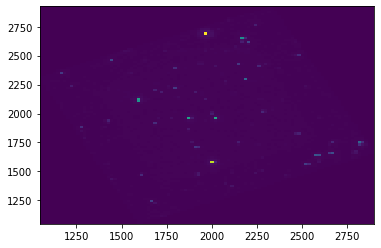

In [255]:
efile=fits.open("/home/limu/Space/data/swift/sw00727541000uuuw1po_uf.evt.gz")
out=pl.hist2d(efile[1].data['X'],efile[1].data['Y'],100)

In [175]:
colors=dict(zip([d.header['EXTNAME'] for d in ofiles[0][1:]  if 'FILTER' in colnames(d)],list('wbmgyrc')))

Text(0.5, 0, 'time[s]')

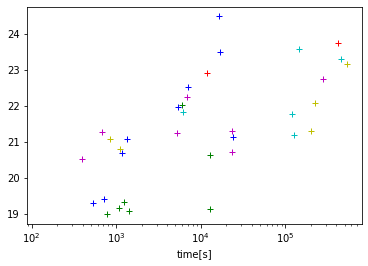

In [179]:
#mcurve={}
for i in range(len(alldata)):
    #b2=np.concatenate([a.T for a in b])
    for j in range(len(alldata[i])):
        c=allfilt[i][j][0]
        #mcurve[c]=mcurve.get(c,[])+list(alldata[i][j].T)
        b2=alldata[i][j].T
        sel=b2[:,2]<50
        pl.semilogx(b2[sel,0],b2[sel,2],'+'+colors[c])
pl.xlabel('time[s]')

In [225]:
np.load("uvotlc/GRB150518A.npz")['U']

array([[1.95865826e+06, 1.32914111e+03, 2.18361359e+01, 4.17890608e-01,
        2.28561344e+01],
       [1.96390846e+06, 1.62413416e+03, 2.26327057e+01, 7.51268566e-01,
        2.36527061e+01],
       [2.28528650e+06, 1.58848438e+03, 2.25935555e+01, 7.28901386e-01,
        2.36135540e+01],
       [2.29154266e+06, 1.55690662e+03, 2.26231995e+01, 7.57398665e-01,
        2.36431980e+01],
       [2.31405671e+06, 1.52924902e+03, 2.14459534e+01, 2.88967162e-01,
        2.24659519e+01],
       [2.62994909e+06, 1.30779248e+03, 2.18579369e+01, 4.34878200e-01,
        2.28779373e+01],
       [2.63542943e+06, 8.18110046e+02, 2.33494205e+01, 1.98330128e+00,
        2.43694210e+01],
       [2.64154688e+06, 1.50936633e+03, 2.21134911e+01, 5.01188815e-01,
        2.31334915e+01],
       [3.65826179e+06, 6.52652954e+02, 2.13567600e+01, 4.83312756e-01,
        2.23767605e+01],
       [3.66399176e+06, 5.93819397e+02, 2.19446640e+01, 8.32995594e-01,
        2.29646645e+01],
       [3.69283315e+06, 7.4837

In [202]:
if False:
    for c in mcurve.keys():
        mcurve[c]=np.array(mcurve[c])
    np.save(open("uvotlc/"+g1.replace(" ","")+".npz","wb"),mcurve,allow_pickle=True)
    print([sum(m[:,1]) for m in mcurve.values()])

[1613.591540813446,
 1913.5937805175781,
 5155.584800720215,
 964.7727088928223,
 7445.718812942505,
 1753.68115234375,
 7995.515874862671]

Text(0.5, 0, 'time[s]')

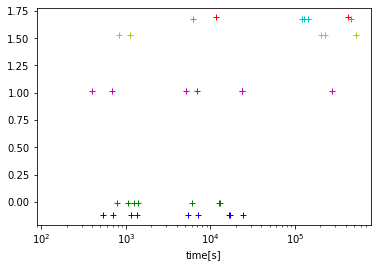

In [186]:
for i in range(len(alldata)):
    #b2=np.concatenate([a.T for a in b])
    for j in range(len(alldata[i])):
        b2=alldata[i][j].T
        sel=b2[:,2]<50
        pl.semilogx(b2[sel,0],b2[sel,4]-b2[sel,2],'+'+colors[allfilt[i][j][0]])
pl.xlabel('time[s]')

In [14]:
from glob import glob
alist=sorted(glob("uvotlc/GRB*z"))
import numpy as np
dall=[np.load(a) for a in alist]

In [19]:
cmplen_U=np.array([len(d['U']) if 'U' in d else 0 for d in dall])
cmplen_W=np.array([len(d['UVW1']) if 'UVW1' in d else 0 for d in dall])
#list(d1.keys())

In [23]:
sel1=np.where((cmplen_U>3)*(cmplen_W>3))[0]

1556

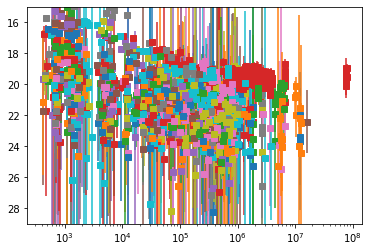

In [49]:
from matplotlib import pyplot as pl
cens=0
for s in sel1:
    d=dall[s]['UVW1']
    sx=d[:,2]<50
    cens+=sum(sx)
    pl.errorbar(d[sx,0],d[sx,2],d[sx,3],d[sx,1]/2,'s')
    ax=pl.gca()
    ax.set_xscale("log")
pl.ylim(29,15)
cens

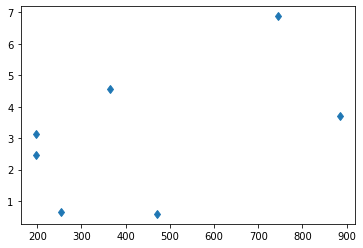

In [45]:
pl.plot(d[sx,1],d[sx,3],'d')

In [33]:
i=sel1[0]
umean=lambda x:x[x!=0].mean()
dif_U=[umean(dall[i]['UVW1'][:,2]-dall[i]['UVW1'][:,4]) for i in sel1]
dif_U
#dall[i]['UVW1'][:,2]

/tmp/ipykernel_4172/172822834.py:2: RuntimeWarning: Mean of empty slice.
  umean=lambda x:x[x!=0].mean()


[-1.5300006866455078,
 -1.5299998196688565,
 -1.5299997744352922,
 -1.529999472878196,
 -1.5299998196688565,
 -1.5299999237060546,
 -1.5299999237060546,
 -1.5300000341315019,
 -1.5299999237060546,
 -1.5300001416887556,
 -1.5299993242536272,
 -1.5300001416887556,
 -1.5299998389350042,
 -1.5299998389350042,
 -1.5300002098083496,
 -1.530000166459517,
 -1.5300004141671317,
 -1.5300003051757813,
 -1.5299999373299735,
 -1.5300000508626301,
 -1.5299999237060546,
 -1.5299996462735264,
 -1.5299997890696806,
 -1.5300000508626301,
 -1.5100000381469727,
 -1.5100001284950657,
 -1.510000142184171,
 -1.510000228881836,
 -1.5100000315699085,
 -1.510000228881836,
 -1.5099997800939224,
 -1.5100000821627104,
 -1.5099998474121095,
 -1.5100001284950657,
 -1.5099999564034599,
 -1.5099998820911755,
 -1.5099998474121095,
 -1.5100000554865056,
 -1.5099997887244592,
 -1.5100000821627104,
 -1.5099999564034599,
 -1.510000228881836,
 -1.510000228881836,
 -1.5099999804149642,
 -1.5100000381469727,
 -1.5099999745686

### VO table for magnitudes

In [12]:
from astropy.io.votable import parse
map1=parse("/home/limu/Space/data/swift/Swift_SSC_UV_votable.xml")
tab1=map1.resources[0].tables[0]
[f.ID for f in tab1.fields]

['w3___row',
 'obsid',
 'source_number',
 'name',
 'ra',
 'ra_error',
 'dec',
 'dec_error',
 'vmag',
 'vmag_error',
 'uvm2_mag',
 'uvm2_mag_error',
 'uvw2_mag',
 'uvw2_mag_error',
 'uvw1_mag',
 'uvw1_mag_error',
 'Search_Offset']

In [ ]:
import requests
SR=3
RA,DEC=12,14
from astropy.table import Table
import io
params = {'table': 'swuvotssc', 'RA': RA, 'DEC':DEC, 'SR':SR}
params['fields']='All'
#r = requests.get('https://heasarc.gsfc.nasa.gov/cgi-bin/vo/cone/coneGet.pl', params=params)
#ra2,dec2=tab1.array['ra'],tab1.array['dec']
#tab2=Table.read(io.BytesIO(r.content))

In [5]:
map2=parse("/home/limu/Space/data/swift/Swift_SSC_UV_multi.xml")
tab2=map2.resources[0].tables[0]

#### SWIFT/UVOT filter parameters [Angstrom] mid+-fwhm
- v 5468 769
- b 4392 975
- u 3465 785
- uvw1 2600 693
- uvm2 2246 498
- uvw2 1928 657

In [18]:
[f.ID for f in tab2.fields]
mag1,mag2,mag3=[tab2.array['uv%s_mag'%a].data for a in "m2,w1,w2".split(',')]

In [19]:
sum(mag1>0),sum(mag2>0),sum(mag3>0)

(299, 182, 519)

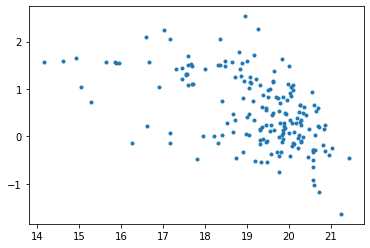

In [22]:
sel=(mag2>0)*(mag3>0)
pl.plot(mag2[sel],mag3[sel]-mag2[sel],'.')

(182, 299, 0.10580000000000211)

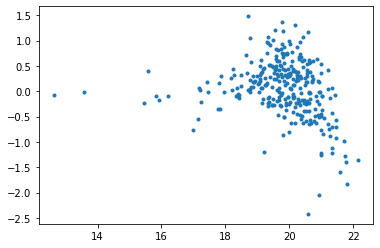

In [25]:
import numpy as np
sel2=(mag1>0)*(mag3>0)
pl.plot(mag1[sel2],mag3[sel2]-mag1[sel2],'.')
sum(sel),sum(sel2),np.median(mag3[sel2]-mag1[sel2])

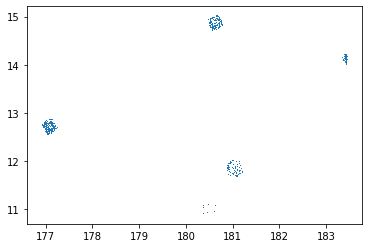

In [8]:
from matplotlib import pyplot as pl
pl.plot(tab2.array['ra'],tab2.array['dec'],',')

171

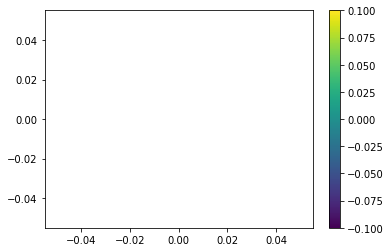

In [31]:
from matplotlib import pyplot as pl
sel=dec>3
umag=tab1.array['uvm2_mag']
pl.scatter(ra[sel],dec[sel],s=1,c=22-umag[sel])
pl.colorbar()
sum(sel)

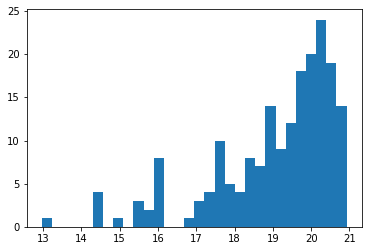

In [17]:
pl.hist(tab1.array['uvm2_mag'],30);

### SIA search

In [37]:
pos='{},{}'.format(RA,DEC)
params = {'survey': 'swiftuvot', 'POS': pos, 'SIZE':'0.03', "NAXIS":"300,300"}
r = requests.get('https://skyview.gsfc.nasa.gov/cgi-bin/vo/sia.pl', params=params)
table=Table.read(io.BytesIO(r.content))
print(table.colnames)

['Survey', 'Ra', 'Dec', 'Dim', 'Size', 'Scale', 'Format', 'PixFlags', 'URL', 'LogicalName']


In [41]:
from IPython.display import Image, display
display(Image(url=table['URL'][5]))

## Chandra data

other tables:

- GALEX	ivo://nasa.heasarc/skyview/galex
- SWIFTUVOT	ivo://nasa.heasarc/skyview/swiftuvot
- SwiftUVOT	ivo://nasa.heasarc/swiftuvlog

In [43]:
import astropy.coordinates as coord
m82=coord.SkyCoord.from_name("m82")
pos='{},{}'.format(m82.ra.deg,m82.dec.deg)
params = {'table': 'chanmaster',"POS":pos,"SIZE":".01", "REQUEST":"queryData"}
try:
    r = requests.get('https://heasarc.nasa.gov/xamin/vo/ssa', params=params)
    spec_table = Table.read(io.BytesIO(r.content))
except:
    print("connection failed")
else:
    spec_table.show_in_notebook()

connection failed


In [46]:
tap_params = {
    "request":"doQuery",
    "lang":"ADQL",
    }
tap_params["query"]="""SELECT ra, dec, bmag, uvm2_mag FROM swuvotssc as cat where 
    contains(point('ICRS',cat.ra,cat.dec),circle('ICRS',{0},{1},{2}))=1 and
    cat.bmag < 14
    order by cat.radial_velocity_error
    """.format(RA,DEC,0.1)
old="""
    select a.name,b.value
      from metainfo a, metainfo b
      where
         a.type='table' and b.type='table' and
         a.relation='defaultSearchRadius' and
         b.relation='description' and
         a.name=b.name and
         b.value like '%Redshift%' 
      order by name    
      """
r = requests.get('https://heasarc.gsfc.nasa.gov/xamin/vo/tap/sync', params=tap_params)
table=Table.read(io.BytesIO(r.content))
table.show_in_notebook()



ValueError: No table found

In [5]:
#from numba import jit
import functools
functools.partial??

Init signature: functools.partial(self, /, *args, **kwargs)
Docstring:     
partial(func, *args, **keywords) - new function with partial application
of the given arguments and keywords.
Source:        
class partial:
    """New function with partial application of the given arguments
    and keywords.
    """

    __slots__ = "func", "args", "keywords", "__dict__", "__weakref__"

    def __new__(cls, func, /, *args, **keywords):
        if not callable(func):
            raise TypeError("the first argument must be callable")

        if hasattr(func, "func"):
            args = func.args + args
            keywords = {**func.keywords, **keywords}
            func = func.func

        self = super(partial, cls).__new__(cls)

        self.func = func
        self.args = args
        self.keywords = keywords
        return self

    def __call__(self, /, *args, **keywords):
        keywords = {**self.keywords, **keywords}
        return self.func(*self.args, *args, **keywords)

    @recur

In [2]:
from scipy.stats.mstats import theilslopes
theilslopes?

Signature: theilslopes(y, x=None, alpha=0.95, method='separate')
Docstring:
Computes the Theil-Sen estimator for a set of points (x, y).

`theilslopes` implements a method for robust linear regression.  It
computes the slope as the median of all slopes between paired values.

Parameters
----------
y : array_like
    Dependent variable.
x : array_like or None, optional
    Independent variable. If None, use ``arange(len(y))`` instead.
alpha : float, optional
    Confidence degree between 0 and 1. Default is 95% confidence.
    Note that `alpha` is symmetric around 0.5, i.e. both 0.1 and 0.9 are
    interpreted as "find the 90% confidence interval".
method : {'joint', 'separate'}, optional
    Method to be used for computing estimate for intercept.
    Following methods are supported,

        * 'joint': Uses np.median(y - slope * x) as intercept.
        * 'separate': Uses np.median(y) - slope * np.median(x)
                      as intercept.

    The default is 'separate'.

    .. ver